# Notebook to make a figure overviewing physical and numerical mixing integrated over the simulations as a function of wind stress 

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from xhistogram.xarray import histogram
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore") #The chaotic option, used to suppress issues with cf_time with xroms 

In [2]:
paths = ['/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_001/shelf_dx_500_uwind_osc_001_avg.nc', #Some of the amplitudes are off by order of magnitude when named
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_002/shelf_dx_500_uwind_osc_002_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_004/shelf_dx_500_uwind_osc_004_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_008/shelf_dx_500_uwind_osc_008_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_01/shelf_dx_500_uwind_osc_01_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_02/shelf_dx_500_uwind_osc_02_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_04/shelf_dx_500_uwind_osc_04_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_08/shelf_dx_500_uwind_osc_08_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_09/shelf_dx_500_uwind_osc_09_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_1/shelf_dx_500_uwind_osc_1_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_2/shelf_dx_500_uwind_osc_2_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_4/shelf_dx_500_uwind_osc_4_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_8/shelf_dx_500_uwind_osc_8_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_10/shelf_dx_500_uwind_osc_10_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_10p5/shelf_dx_500_uwind_osc_10p5_avg.nc',]

def open_roms(path):
    ds = xroms.open_netcdf(path)
    ds, grid = xroms.roms_dataset(ds)
    return ds, grid

ds = []
grid = []
for i in range(len(paths)):
    dsa, grida = open_roms(paths[i])
    # Add 4 days to account for the change in initial condition b.c. ROMS counts at 1, NOT ZERO
    dsa['ocean_time'] = dsa.ocean_time[:]+timedelta(days=4) 
    ds.append(dsa)
    grid.append(grida)
    
# Open the model basecase to examine the times for normalizing energy. Energy should be done with history files because 
# average files are outputted at the 30 minute mark, i.e., the along-shelf velocity != 0 at t = 30:00 only t = 0 . 
path1 = '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_0_f_43N/shelf_dx_500_uwind_0_f_43N_open_his.nc'
ds_base = xroms.open_netcdf(path1)
ds_base, grid_base = xroms.roms_dataset(ds_base)

In [3]:
time = np.arange(0,len(ds[0].ocean_time))/24 #Crude time vector, could do this a fancier way but meh. 
time+=5
print(time[0])
print(time[-1])
print(ds[0].ocean_time[0].values)
print(ds[0].ocean_time[-1].values)

5.0
21.958333333333332
0001-01-05 00:30:00
0001-01-21 23:30:00


In [4]:
# Open the mixing outputs 
paths = ['/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_001_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_002_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_004_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_008_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_01_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_02_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_04_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_08_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_09_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_1_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_2_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_4_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_8_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_10_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_10p5_mix.nc']
mix = []
for i in range(len(paths)):
    dso = xr.open_dataset(paths[i])
    dso['ocean_time'] = dso.ocean_time[:]+timedelta(days=4)
    mix.append(dso)

In [11]:
tslice = slice(60+24,241+24) 
# Reminder - we want to be + 1 days ahead of target since time series starts from zero
print(ds[0].isel(ocean_time = tslice).ocean_time[0].values)
print(ds[0].isel(ocean_time = tslice).ocean_time[-1].values)
#Double check mixing times line up with the model output just to be safe
print(mix[0].isel(ocean_time = tslice).ocean_time[0].values)
print(mix[0].isel(ocean_time = tslice).ocean_time[-1].values)

tslice1 = slice(0+24,360+24)
print(ds[0].isel(ocean_time = tslice1).ocean_time[0].values)
print(ds[0].isel(ocean_time = tslice1).ocean_time[-1].values)
#Double check mixing times line up with the model output just to be safe
print(mix[0].isel(ocean_time = tslice1).ocean_time[0].values)
print(mix[0].isel(ocean_time = tslice1).ocean_time[-1].values)

0001-01-08 12:30:00
0001-01-16 00:30:00
0001-01-08 12:30:00
0001-01-16 00:30:00
0001-01-06 00:30:00
0001-01-20 23:30:00
0001-01-06 00:30:00
0001-01-20 23:30:00


In [6]:
r = []
rextend = []
for i in range(len(paths)):
    ratio = mix[i].mnum_int.isel(ocean_time = tslice).sum().values/(mix[i].mphy_int.isel(ocean_time = tslice).sum().values)
    ratio1 = mix[i].mnum_int.isel(ocean_time = tslice1).sum().values/(mix[i].mphy_int.isel(ocean_time = tslice1).sum().values)
    r.append(ratio)
    rextend.append(ratio1)
r = np.array(r)
rextend = np.array(rextend)
print(r)
print(rextend)

[0.06573894 0.0657611  0.06656    0.07002384 0.07316389 0.08162991
 0.12149962 0.14379549 0.15487968 0.15406601 0.10785725 0.0652345
 0.01605446 0.01178786 0.01145851]
[0.06227057 0.0624363  0.06280227 0.06389313 0.06683756 0.07426985
 0.11641079 0.13964156 0.14809095 0.14796511 0.1058754  0.06645449
 0.01495182 0.01105791 0.01057962]


In [7]:
tx = np.array([0.001, 0.002, 0.004, 0.008, 0.01, 0.02, 0.04, 0.08, 0.09, 0.1, 0.2, 0.4, 0.8, 1, 1.5])

r11 = []
r12 = []
r13 = []
r14 = []
for i in range(len(paths)):
    ratio = mix[i].mnum_int.isel(ocean_time = tslice).sum().values
    ratio1 = mix[i].mphy_int.isel(ocean_time = tslice).sum().values
    ratio2 = mix[i].mnum_int.isel(ocean_time = tslice1).sum().values
    ratio3 = mix[i].mphy_int.isel(ocean_time = tslice1).sum().values
    r11.append(ratio)
    r12.append(ratio1)
    r13.append(ratio2)
    r14.append(ratio3)
r1 = np.array(r11)
r2 = np.array(r12)
r3 = np.array(r13)
r4 = np.array(r14)
print(r1)
print(r2)
print(r3)
print(r4)

[ 786448.75402115  786434.32913518  793797.63440307  835880.1599111
  871890.07182215  957801.17396306 1546389.60776278 2534840.68126613
 2981161.85578148 3228624.64222545 3269165.20719036 3098001.55581738
  676661.44564486  437396.74051007  325559.91081281]
[11963210.00428038 11958958.83640796 11926046.89108867 11937079.85659462
 11916945.1618914  11733458.42021755 12727526.69021756 17628095.32269029
 19248243.73914839 20956112.12129505 30310111.38540963 47490229.90374335
 42147872.96361285 37105707.00376806 28412065.28655223]
[1466536.47646919 1473612.39472281 1506395.58802836 1522691.70017733
 1588840.20192484 1747639.08145843 2853307.37209921 4913691.88800208
 5582531.31633026 5900477.07746916 6362117.21053116 5516712.81097703
 1132059.72098444  720951.97388029  499576.58901069]
[23551036.01916587 23601854.44781751 23986324.60346091 23831854.6537744
 23771666.08343869 23530935.51354676 24510677.61850549 35187889.46773218
 37696639.96168894 39877490.37467755 60090610.35664114 830149

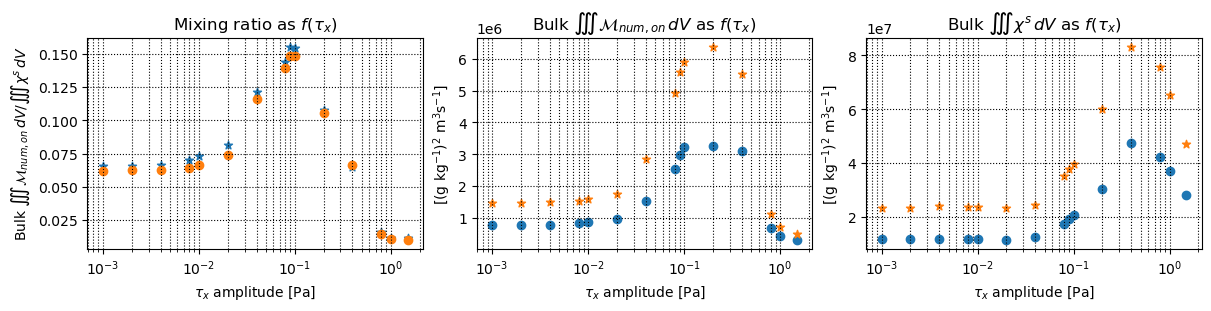

In [9]:
fig, ax = plt.subplots(1,3, figsize = (12,3), constrained_layout = True)

ax[0].scatter(tx,r, marker = '*')
ax[0].scatter(tx,rextend)
ax[0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[0].set_ylabel('Bulk $\iiint \mathcal{M}_{num,on} \, dV / \iiint \chi^s \, dV$')
ax[0].set_title(r'Mixing ratio as $f(\tau_x)$')

ax[1].scatter(tx,r1)
ax[1].scatter(tx,r3, marker = '*')
ax[1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[1].set_title(r'Bulk $\iiint \mathcal{M}_{num,on} \, dV$ as $f(\tau_x)$')

ax[2].scatter(tx,r2)
ax[2].scatter(tx,r4, marker = '*')
ax[2].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[2].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[2].set_title(r'Bulk $\iiint \chi^s \, dV$ as $f(\tau_x)$')
ax[2].grid(which = 'both')
for i in range(3):
    ax[i].semilogx()
    ax[i].grid(which = 'both', ls = ':', c = 'k')
    # ax[i].semilogy()
# plt.savefig('mixing_function_taux')

In [14]:
s = np.load('/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mean_shgrad_allsims_day7p5_15.npy')
sv = np.load('/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mean_shvgrad_allsims_day7p5_15.npy')
diffu = np.load('/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mean_sdfiffsuvity_allsims_day7pt_15.npy')
s1 = np.load('/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mean_shgrad_allsims_day5_20.npy')
sv1 = np.load('/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mean_shvgrad_allsims_day5_20.npy')
diffu1 = np.load('/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mean_sdfiffsuvity_allsims_day5_20.npy')

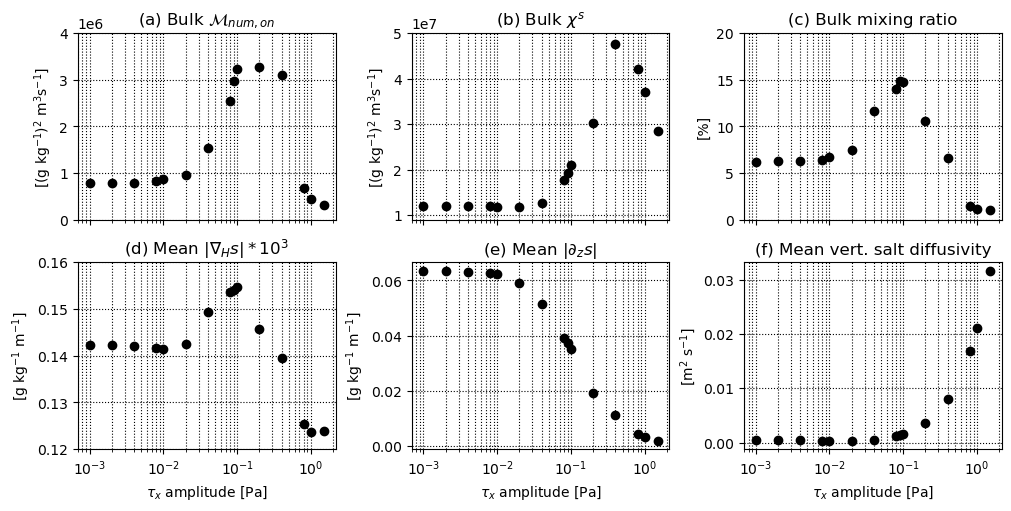

In [15]:
fig, ax = plt.subplots(2,3, figsize = (10,5), constrained_layout = True)

ax[0,0].scatter(tx,r1, c = 'k')
# ax[0,0].semilogy()
ax[0,0].set_xlabel(r'')
ax[0,0].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,0].set_title(r'(a) Bulk $\mathcal{M}_{num,on}$')
ax[0,0].set_ylim(0, 4e6)


ax[0,1].scatter(tx, r2, c = 'k')
# ax[0,1].semilogy()
ax[0,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[0,1].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,1].set_title(r'(b) Bulk $\chi^s$')
ax[0,1].set_ylim(0.9e7, 5e7)

ax[1,0].scatter(tx,np.array(s)*1000, c = 'k')
ax[1,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,0].set_ylabel(r'[g kg$^{-1}$ m$^{-1}$]')
ax[1,0].set_title(r'(d) Mean $|\nabla_H s|*10^3$')
ax[1,0].set_ylim(0.12, 0.16)

ax[1,1].scatter(tx, np.abs(sv), c = 'k')
ax[1,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,1].set_ylabel(r'[g kg$^{-1}$ m$^{-1}$]')
ax[1,1].set_title(r'(e) Mean $|\partial_z s|$')

ax[0,2].scatter(tx,np.array(rextend*100), c = 'k')
ax[0,2].set_xlabel(r'')
ax[0,2].set_ylabel(r'[%]')
ax[0,2].set_title(r'(c) Bulk mixing ratio')
ax[0,2].set_ylim(0,20)

ax[1,2].scatter(tx, diffu, c = 'k')
ax[1,2].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].set_ylabel(r'[m$^2$ s$^{-1}$]')
ax[1,2].set_title(r'(f) Mean vert. salt diffusivity')

for i in range(2):
    for j in range(3):
        ax[i,j].semilogx()
        ax[0,j].set_xticklabels('')
        # ax[i,j].semilogy(base = 2)
        ax[0,i].set_xlabel('')
        ax[i,j].grid(which = 'both', ls = ':', c = 'k')
# plt.savefig('mixing_function_taux.jpg', dpi = 300)

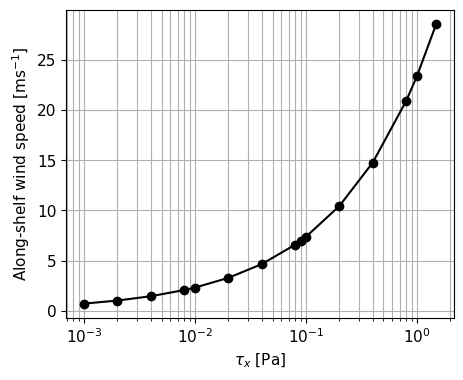

In [16]:
tx = np.array([0.001, 0.002, 0.004, 0.008, 0.01, 0.02, 0.04, 0.08, 0.09, 0.1, 0.2, 0.4, 0.8, 1, 1.5])
cd = 0.0015
rhoa = 1.225
u = np.sqrt(tx/(rhoa*cd))

plt.rcParams.update({'font.size': 11})
fig, ax = plt.subplots(1, figsize = (5,4))

ax.semilogx(tx, u, color = 'k', marker = 'o')
ax.set_ylabel(r'Along-shelf wind speed [ms$^{-1}$]')
ax.set_xlabel(r'$\tau_x$ [Pa]')
ax.grid(which = 'both')
# plt.savefig('wind_stress_speed.jpg', dpi = 300, bbox_inches='tight')

### List the wind speed values so they can described in text 

In [ ]:
print('Wind speed [m/s]', u)
print('Wind stress [Pa]', tx)

### Now merge the two subplots 

Text(0.5, 0, '$\\tau_x$ amplitude [Pa]')

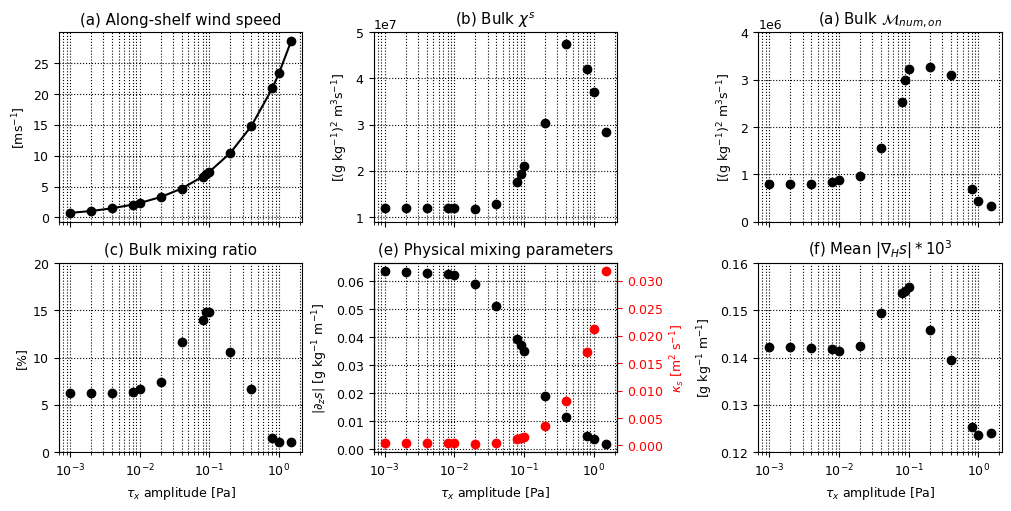

In [14]:
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(2,3, figsize = (10,5), constrained_layout = True)

ax[0,0].semilogx(tx, u, color = 'k', marker = 'o')
ax[0,0].set_ylabel(r'[ms$^{-1}$]')
ax[0,0].set_xlabel(r'$\tau_x$ [Pa]')
ax[0,0].grid(which = 'both')
ax[0,0].set_title('(a) Along-shelf wind speed')
ax[0,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')

ax[1,0].scatter(tx,np.array(rextend*100), c = 'k')
ax[1,0].set_xlabel(r'')
ax[1,0].set_ylabel(r'[%]')
ax[1,0].set_title(r'(c) Bulk mixing ratio')
ax[1,0].set_ylim(0,20)
ax[1,0].grid(which = 'both')

ax[0,1].scatter(tx, r2, c = 'k')
# ax[0,1].semilogy()
ax[0,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[0,1].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,1].set_title(r'(b) Bulk $\chi^s$')
ax[0,1].set_ylim(0.9e7, 5e7)

ax[0,2].scatter(tx,r1, c = 'k')
# ax[0,0].semilogy()
ax[0,2].set_xlabel(r'')
ax[0,2].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,2].set_title(r'(a) Bulk $\mathcal{M}_{num,on}$')
ax[0,2].set_ylim(0, 4e6)

ax[1,2].scatter(tx,np.array(s)*1000, c = 'k')
ax[1,2].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].set_ylabel(r'[g kg$^{-1}$ m$^{-1}$]')
ax[1,2].set_title(r'(f) Mean $|\nabla_H s|*10^3$')
ax[1,2].set_ylim(0.12, 0.16)

ax[1,1].scatter(tx, np.abs(sv), c = 'k', label = '')
ax[1,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,1].set_ylabel(r'$|\partial_z s|$ [g kg$^{-1}$ m$^{-1}$]')
ax[1,1].set_title(r'(e) Physical mixing parameters')

ax2 = ax[1,1].twinx()
ax2.scatter(tx, diffu, c = 'r', label = '')
ax2.set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax2.set_ylabel(r'$\kappa_s$ [m$^2$ s$^{-1}$]')
ax2.tick_params(axis='y', colors='red')
ax2.yaxis.label.set_color('red')

for i in range(2):
    for j in range(3):
        ax[i,j].semilogx()
        ax[0,j].set_xticklabels('')
        # ax[i,j].semilogy(base = 2)
        ax[0,i].set_xlabel('')
        ax[i,j].grid(which = 'both', ls = ':', c = 'k')
ax[1,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
# plt.savefig('mixing_function_taux.jpg', dpi = 300)

# Flip second and third columns. Spacing looks awkward as is because of the twin axes, 

In [15]:
# rextend is mixing ratio, r3 is bulk numerical, r4 is bulk physical

Text(0.08, 0.053, '[g kg$^{-1}$ m$^{-1}$]')

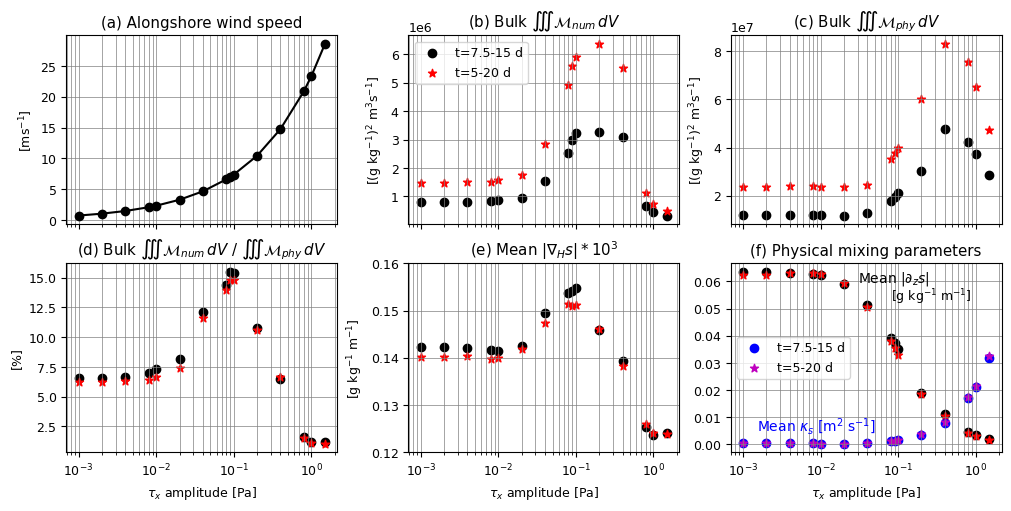

In [16]:
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(2,3, figsize = (10,5), constrained_layout = True)

ax[0,0].semilogx(tx, u, color = 'k', marker = 'o')
ax[0,0].set_ylabel(r'[ms$^{-1}$]')
ax[0,0].set_xlabel(r'$\tau_x$ [Pa]')
ax[0,0].grid(which = 'both')
ax[0,0].set_title('(a) Alongshore wind speed')
ax[0,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')

ax[0,1].scatter(tx,r1, c = 'k', label = 't=7.5-15 d')
ax[0,1].scatter(tx,r3, c = 'r', marker = '*', label = 't=5-20 d')
ax[0,1].set_xlabel(r'')
ax[0,1].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,1].set_title(r'(b) Bulk $\iiint \mathcal{M}_{num} \, dV$')
ax[0,1].legend()
# ax[0,1].set_ylim(0, 4e6)

ax[0,2].scatter(tx,r2, c = 'k')
ax[0,2].scatter(tx,r4, c = 'r', marker = '*')
ax[0,2].set_xlabel(r'')
ax[0,2].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,2].set_title(r'(c) Bulk $\iiint \mathcal{M}_{phy} \, dV$')
# ax[0,2].set_ylim(0.9e7, 5e7)

ax[1,0].scatter(tx,np.array(r)*100, c = 'k')
ax[1,0].scatter(tx,np.array(rextend)*100, c = 'r', marker = '*')
ax[1,0].set_xlabel(r'')
ax[1,0].set_ylabel(r'[%]')
ax[1,0].set_title(r'(d) Bulk $\iiint \mathcal{M}_{num} \, dV$ / $\iiint \mathcal{M}_{phy} \, dV$')
# ax[1,0].set_ylim(0,18)
ax[1,0].grid(which = 'both')

ax[1,1].scatter(tx,np.array(s)*1000, c = 'k')
ax[1,1].scatter(tx,np.array(s1)*1000, c = 'r', marker = '*')
ax[1,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,1].set_ylabel(r'[g kg$^{-1}$ m$^{-1}$]')
ax[1,1].set_title(r'(e) Mean $|\nabla_H s|*10^3$')
ax[1,1].set_ylim(0.12, 0.16)

ax[1,2].scatter(tx, np.abs(sv), c = 'k', label = '')
ax[1,2].scatter(tx,np.abs(sv1), c = 'r', marker = '*')
ax[1,2].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].set_ylabel(r'')
ax[1,2].set_title(r'(f) Physical mixing parameters')
ax[1,2].scatter(tx, diffu, c = 'b', label = 't=7.5-15 d')
ax[1,2].scatter(tx, diffu1, c = 'm', label = 't=5-20 d', marker = '*')
ax[1,2].legend(loc='center left')

for i in range(2):
    for j in range(3):
        ax[i,j].semilogx()
        ax[0,j].set_xticklabels('')
        # ax[i,j].semilogy(base = 2)
        ax[0,i].set_xlabel('')
        ax[i,j].grid(which = 'both', ls = '-', c = 'grey', lw = 0.5)
ax[1,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].text(0.0015,0.005,'Mean $\kappa_s$ [m$^2$ s$^{-1}$]', color = 'blue', fontsize = 10)
ax[1,2].text(0.03,0.06,'Mean $|\partial_z s|$', color = 'black', fontsize = 10)# 
ax[1,2].text(0.08,0.053,'[g kg$^{-1}$ m$^{-1}$]', color = 'black', fontsize = 9)# 
# plt.savefig('mixing_function_taux.jpg', dpi = 300)

Text(0.08, 0.053, '[g kg$^{-1}$ m$^{-1}$]')

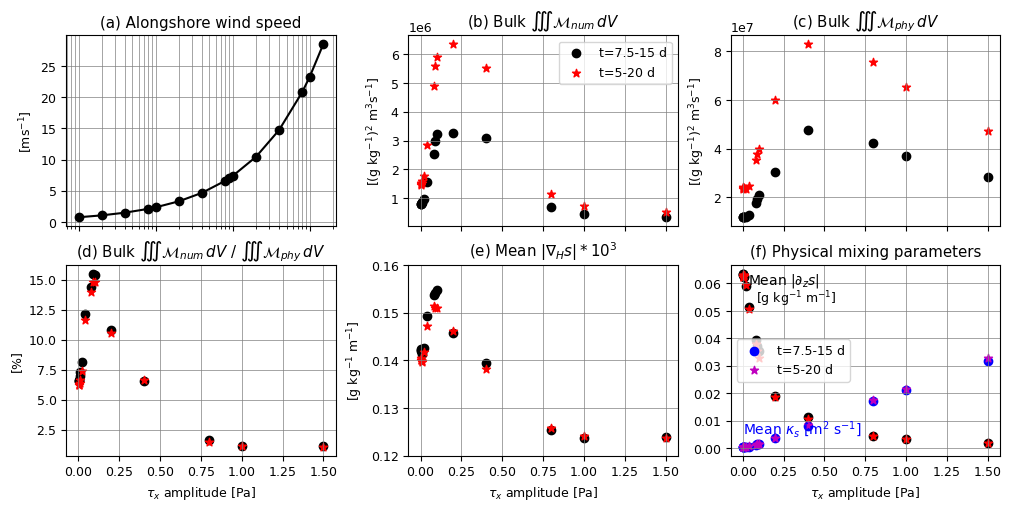

In [17]:
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(2,3, figsize = (10,5), constrained_layout = True)

ax[0,0].semilogx(tx, u, color = 'k', marker = 'o')
ax[0,0].set_ylabel(r'[ms$^{-1}$]')
ax[0,0].set_xlabel(r'$\tau_x$ [Pa]')
ax[0,0].grid(which = 'both')
ax[0,0].set_title('(a) Alongshore wind speed')
ax[0,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')

ax[0,1].scatter(tx,r1, c = 'k', label = 't=7.5-15 d')
ax[0,1].scatter(tx,r3, c = 'r', marker = '*', label = 't=5-20 d')
ax[0,1].set_xlabel(r'')
ax[0,1].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,1].set_title(r'(b) Bulk $\iiint \mathcal{M}_{num} \, dV$')
ax[0,1].legend()
# ax[0,1].set_ylim(0, 4e6)

ax[0,2].scatter(tx,r2, c = 'k')
ax[0,2].scatter(tx,r4, c = 'r', marker = '*')
ax[0,2].set_xlabel(r'')
ax[0,2].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,2].set_title(r'(c) Bulk $\iiint \mathcal{M}_{phy} \, dV$')
# ax[0,2].set_ylim(0.9e7, 5e7)

ax[1,0].scatter(tx,np.array(r)*100, c = 'k')
ax[1,0].scatter(tx,np.array(rextend)*100, c = 'r', marker = '*')
ax[1,0].set_xlabel(r'')
ax[1,0].set_ylabel(r'[%]')
ax[1,0].set_title(r'(d) Bulk $\iiint \mathcal{M}_{num} \, dV$ / $\iiint \mathcal{M}_{phy} \, dV$')
# ax[1,0].set_ylim(0,18)
ax[1,0].grid(which = 'both')

ax[1,1].scatter(tx,np.array(s)*1000, c = 'k')
ax[1,1].scatter(tx,np.array(s1)*1000, c = 'r', marker = '*')
ax[1,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,1].set_ylabel(r'[g kg$^{-1}$ m$^{-1}$]')
ax[1,1].set_title(r'(e) Mean $|\nabla_H s|*10^3$')
ax[1,1].set_ylim(0.12, 0.16)

ax[1,2].scatter(tx, np.abs(sv), c = 'k', label = '')
ax[1,2].scatter(tx,np.abs(sv1), c = 'r', marker = '*')
ax[1,2].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].set_ylabel(r'')
ax[1,2].set_title(r'(f) Physical mixing parameters')
ax[1,2].scatter(tx, diffu, c = 'b', label = 't=7.5-15 d')
ax[1,2].scatter(tx, diffu1, c = 'm', label = 't=5-20 d', marker = '*')
ax[1,2].legend(loc='center left')

for i in range(2):
    for j in range(3):
        # ax[i,j].semilogx()
        ax[0,j].set_xticklabels('')
        # ax[i,j].semilogy(base = 2)
        ax[0,i].set_xlabel('')
        ax[i,j].grid(which = 'both', ls = '-', c = 'grey', lw = 0.5)
ax[1,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].text(0.0015,0.005,'Mean $\kappa_s$ [m$^2$ s$^{-1}$]', color = 'blue', fontsize = 10)
ax[1,2].text(0.03,0.06,'Mean $|\partial_z s|$', color = 'black', fontsize = 10)# 
ax[1,2].text(0.08,0.053,'[g kg$^{-1}$ m$^{-1}$]', color = 'black', fontsize = 9)# 
# plt.savefig('mixing_function_taux.jpg', dpi = 300)

### Load in realistic model output - parent model subsetted to location of child grid
Get mean value of wind-stress and wind-speed amplitude 

In [19]:
path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
ds_avg = xroms.open_mfnetcdf(path)
ds_avg, grid_avg = xroms.roms_dataset(ds_avg)

#Parent model slices
xislice = slice(271,404)
etaslice = slice(31,149)

In [20]:
su_rho = grid_avg.interp(ds_avg.sustr, 'X', boundary = 'extend') #boundary = extend is a no gradient condition
sv_rho = grid_avg.interp(ds_avg.svstr, 'Y', boundary = 'extend')

su_ew = su_rho*np.cos(ds_avg.angle)-(sv_rho*np.sin(ds_avg.angle)) #East-west
sv_ns = sv_rho*np.cos(ds_avg.angle)+(su_rho*np.sin(ds_avg.angle)) #North-south

su_avg = su_ew.isel(eta_rho = etaslice, xi_rho = xislice).mean(['eta_rho', 'xi_rho']).sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1].load()
sv_avg = sv_ns.isel(eta_rho = etaslice, xi_rho = xislice).mean(['eta_rho', 'xi_rho']).sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1].load()

In [21]:
# Wind speed 
uwind_ew = ds_avg.Uwind*np.cos(ds_avg.angle)-(ds_avg.Uwind*np.sin(ds_avg.angle)) #East-west
vwind_ns = ds_avg.Vwind*np.cos(ds_avg.angle)+(ds_avg.Vwind*np.sin(ds_avg.angle)) #North-south

uwind_avg = uwind_ew.isel(eta_rho = etaslice, xi_rho = xislice).mean(['eta_rho', 'xi_rho']).sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1].load()
vwind_avg = vwind_ns.isel(eta_rho = etaslice, xi_rho = xislice).mean(['eta_rho', 'xi_rho']).sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1].load()

wndspeed = np.sqrt(uwind_avg**2+vwind_avg**2)

In [22]:
wndm = uwind_ew.isel(eta_rho = etaslice, xi_rho = xislice)**2+vwind_ns.isel(eta_rho = etaslice, xi_rho = xislice)**2
np.sqrt(wndm.max().values)

13.484035656282437

In [23]:
# print(su_avg.mean().values)
# print(sv_avg.mean().values)
# print(wndspeed.mean().values)
# print(uwind_ew.isel(eta_rho = etaslice, xi_rho = xislice).max().values)
# print(vwind_ns.isel(eta_rho = etaslice, xi_rho = xislice).max().values)
# print(((uwind_ew**2+vwind_ns**2)**(1/2)).isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time = slice('2010-06-03', '2010-07-13')).mean().values)
# print(((su_ew**2+sv_ns**2)**(1/2)).isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time = slice('2010-06-03', '2010-07-13')).mean().values)

Text(0.08, 0.053, '[g kg$^{-1}$ m$^{-1}$]')

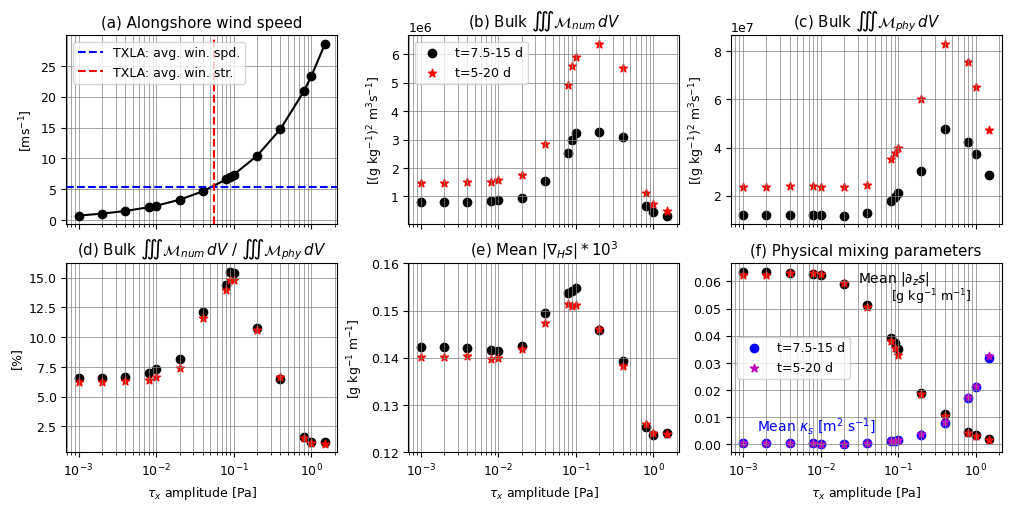

In [24]:
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(2,3, figsize = (10,5), constrained_layout = True)

ax[0,0].semilogx(tx, u, color = 'k', marker = 'o')
ax[0,0].set_ylabel(r'[ms$^{-1}$]')
ax[0,0].set_xlabel(r'$\tau_x$ [Pa]')
ax[0,0].grid(which = 'both')
ax[0,0].set_title('(a) Alongshore wind speed')
ax[0,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[0,0].axhline(5.3762, c = 'b', ls = '--', label = 'TXLA: avg. win. spd.')
ax[0,0].axvline(0.055113, c = 'r', ls = '--', label = 'TXLA: avg. win. str.')
ax[0,0].legend()

ax[0,1].scatter(tx,r1, c = 'k', label = 't=7.5-15 d')
ax[0,1].scatter(tx,r3, c = 'r', marker = '*', label = 't=5-20 d')
ax[0,1].set_xlabel(r'')
ax[0,1].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,1].set_title(r'(b) Bulk $\iiint \mathcal{M}_{num} \, dV$')
ax[0,1].legend()

ax[0,2].scatter(tx,r2, c = 'k')
ax[0,2].scatter(tx,r4, c = 'r', marker = '*')
ax[0,2].set_xlabel(r'')
ax[0,2].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,2].set_title(r'(c) Bulk $\iiint \mathcal{M}_{phy} \, dV$')

ax[1,0].scatter(tx,np.array(r)*100, c = 'k')
ax[1,0].scatter(tx,np.array(rextend)*100, c = 'r', marker = '*')
ax[1,0].set_xlabel(r'')
ax[1,0].set_ylabel(r'[%]')
ax[1,0].set_title(r'(d) Bulk $\iiint \mathcal{M}_{num} \, dV$ / $\iiint \mathcal{M}_{phy} \, dV$')
ax[1,0].grid(which = 'both')

ax[1,1].scatter(tx,np.array(s)*1000, c = 'k')
ax[1,1].scatter(tx,np.array(s1)*1000, c = 'r', marker = '*')
ax[1,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,1].set_ylabel(r'[g kg$^{-1}$ m$^{-1}$]')
ax[1,1].set_title(r'(e) Mean $|\nabla_H s|*10^3$')
ax[1,1].set_ylim(0.12, 0.16)

ax[1,2].scatter(tx, np.abs(sv), c = 'k', label = '')
ax[1,2].scatter(tx,np.abs(sv1), c = 'r', marker = '*')
ax[1,2].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].set_ylabel(r'')
ax[1,2].set_title(r'(f) Physical mixing parameters')
ax[1,2].scatter(tx, diffu, c = 'b', label = 't=7.5-15 d')
ax[1,2].scatter(tx, diffu1, c = 'm', label = 't=5-20 d', marker = '*')
ax[1,2].legend(loc='center left')

for i in range(2):
    for j in range(3):
        ax[i,j].semilogx()
        ax[0,j].set_xticklabels('')
        # ax[i,j].semilogy(base = 2)
        ax[0,i].set_xlabel('')
        ax[i,j].grid(which = 'both', ls = '-', c = 'grey', lw = 0.5)
ax[1,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].text(0.0015,0.005,'Mean $\kappa_s$ [m$^2$ s$^{-1}$]', color = 'blue', fontsize = 10)
ax[1,2].text(0.03,0.06,'Mean $|\partial_z s|$', color = 'black', fontsize = 10)# 
ax[1,2].text(0.08,0.053,'[g kg$^{-1}$ m$^{-1}$]', color = 'black', fontsize = 9)# 
# plt.savefig('mixing_function_taux.jpg', dpi = 300)

### Now extract the mean diurnal motion amplitude from the wind stress and wind speed.
> - code below taken for surface currents from ```Diurnal variability analysis.ipynb``` by Rob Hetland
> - $U_{i} = \int u \exp(-i \omega t) \, dt$
> - $V_{i} = \int v \exp(-i \omega t) \, dt$

In [26]:
tslice_txla = slice('2010-6-20 12:30', '2010-6-26 12:30') 
wndm = uwind_ew.isel(eta_rho = etaslice, xi_rho = xislice)**2+vwind_ns.isel(eta_rho = etaslice, xi_rho = xislice)**2

<xarray.DataArray (ocean_time: 1080, eta_rho: 118, xi_rho: 133)>
dask.array<add, shape=(1080, 118, 133), dtype=float64, chunksize=(1, 118, 133), chunktype=numpy.ndarray>
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(118, 133), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(118, 133), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2010-06-02T18:30:00 ... 2010-07-1...
  * xi_rho      (xi_rho) int64 271 272 273 274 275 276 ... 399 400 401 402 403
  * eta_rho     (eta_rho) int64 31 32 33 34 35 36 37 ... 143 144 145 146 147 148
Attributes:
    long_name:  time-averaged surface u-wind component
    units:      meter second-1
    time:       ocean_time
    grid:       <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * cente...
    location:   face
    field:      u-wind, scalar, series

In [27]:
u = ds_avg.u.sel(ocean_time = tslice_txla).isel(s_rho = -1, eta_rho = etaslice, xi_u = xislice)#[:,50,50]
v = ds_avg.v.sel(ocean_time = tslice_txla).isel(s_rho = -1, eta_v = etaslice, xi_rho = xislice)#[:,50,50]

up = 0.5*(u[:, 1:, :]+u[:, :-1, :])
vp = 0.5*(v[:, :, 1:]+v[:, :, :-1])

fd = 2*np.pi/86400.0 # exactly diurnal

dt = 3600.0                          # 1 hour in seconds
t = np.arange(up.shape[0])*3600.0     # create time array in seconds
Ui = np.sum(up * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Vi = np.sum(vp * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Ai = Ui + Vi

### Need to do the interpolation with xarray

In [28]:
u_rho = xroms.to_rho(ds_avg.u, grid_avg).sel(ocean_time = tslice_txla).isel(s_rho = -1, eta_rho = etaslice, xi_rho = xislice).load()
v_rho = xroms.to_rho(ds_avg.v, grid_avg).sel(ocean_time = tslice_txla).isel(s_rho = -1, eta_rho = etaslice, xi_rho = xislice).load()

In [29]:
fd = 2*np.pi/86400.0 # exactly diurnal
dt = 3600.0                          # 1 hour in seconds
t = np.arange(u_rho.shape[0])*3600.0     # create time array in seconds
Ui = np.sum(u_rho * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Vi = np.sum(v_rho * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Ai = Ui + Vi

Text(0.5, 1.0, 'Surface currents: June 20-26 12:30, 2010')

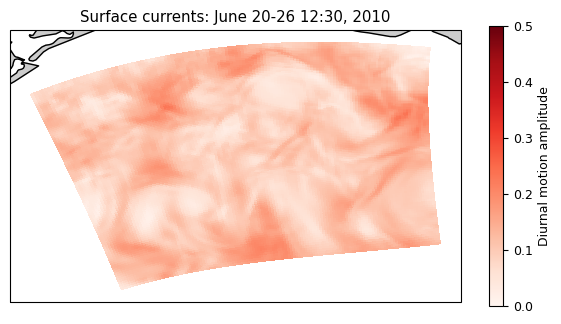

In [30]:
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-92.5)

fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(221, projection=ccrs.PlateCarree())
pcA = ax.pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice), ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice), np.abs(Ai), 
                     cmap=plt.cm.Reds, transform=ccrs.PlateCarree(), vmin=0, vmax=0.5)
plt.colorbar(pcA).set_label('Diurnal motion amplitude')

ax.add_feature(land_10m, facecolor='0.8', linewidth = 1) # add land
ax.coastlines(resolution='10m', linewidth = 1)  # add coastlines 
ax.add_feature(cartopy.feature.RIVERS, lw = 2) # add rivers
ax.set_title('Surface currents: June 20-26 12:30, 2010')

### Now repeat this with wind speed 

In [31]:
uwind_rho = xroms.to_rho(ds_avg.Uwind, grid_avg).sel(ocean_time = tslice_txla).isel(eta_rho = etaslice, xi_rho = xislice).load()
vwind_rho = xroms.to_rho(ds_avg.Vwind, grid_avg).sel(ocean_time = tslice_txla).isel(eta_rho = etaslice, xi_rho = xislice).load()

In [32]:
fd = 2*np.pi/86400.0 # exactly diurnal
dt = 3600.0                          # 1 hour in seconds
t = np.arange(u_rho.shape[0])*3600.0     # create time array in seconds
Ui_wind = np.sum(uwind_rho**2 * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Vi_wind = np.sum(vwind_rho**2 * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Ai_wind = Ui_wind + Vi_wind
print(np.mean(np.sqrt(np.abs(Ai_wind))).values)

1.895484986600529


In [33]:
fd = 2*np.pi/86400.0 # exactly diurnal
dt = 3600.0                          # 1 hour in seconds
t = np.arange(u_rho.shape[0])*3600.0     # create time array in seconds
Ui_wind = np.sum(uwind_rho * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Vi_wind = np.sum(vwind_rho * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Ai_wind = Ui_wind + Vi_wind
print(np.mean(np.abs(Ai_wind)).values)

0.8143654238924006


Text(0.5, 1.0, 'Surface wind speed: June 20-26 12:30, 2010')

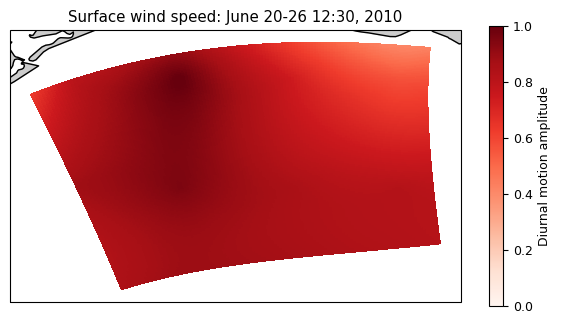

In [34]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(221, projection=ccrs.PlateCarree())
pcA = ax.pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice), ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice), np.abs(Ai_wind), 
                     cmap=plt.cm.Reds, transform=ccrs.PlateCarree(), vmin=0, vmax=1)
plt.colorbar(pcA).set_label('Diurnal motion amplitude')

ax.add_feature(land_10m, facecolor='0.8', linewidth = 1) # add land
ax.coastlines(resolution='10m', linewidth = 1)  # add coastlines 
ax.add_feature(cartopy.feature.RIVERS, lw = 2) # add rivers
ax.set_title('Surface wind speed: June 20-26 12:30, 2010')

### Repeat for stress 

In [35]:
ustr_rho = xroms.to_rho(ds_avg.sustr, grid_avg).sel(ocean_time = tslice_txla).isel(eta_rho = etaslice, xi_rho = xislice).load()
vstr_rho = xroms.to_rho(ds_avg.svstr, grid_avg).sel(ocean_time = tslice_txla).isel(eta_rho = etaslice, xi_rho = xislice).load()

In [36]:
fd = 2*np.pi/86400.0 # exactly diurnal
dt = 3600.0                          # 1 hour in seconds
t = np.arange(ustr_rho.shape[0])*3600.0     # create time array in seconds
Ui_windstr = np.sum(ustr_rho * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Vi_windstr = np.sum(vstr_rho * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Ai_windstr = Ui_windstr+ Vi_windstr
print(np.mean(np.abs(Ai_windstr)).values)

0.004557385600478249


### Now repeat this for the entire simulation analyzed in Schlichting et al. 2023 JAMES

In [37]:
tslice_txla = slice('2010-06-03', '2010-07-13')
uwind_rho = xroms.to_rho(ds_avg.Uwind, grid_avg).sel(ocean_time = tslice_txla).isel(eta_rho = etaslice, xi_rho = xislice).load()
vwind_rho = xroms.to_rho(ds_avg.Vwind, grid_avg).sel(ocean_time = tslice_txla).isel(eta_rho = etaslice, xi_rho = xislice).load()
ustr_rho = xroms.to_rho(ds_avg.sustr, grid_avg).sel(ocean_time = tslice_txla).isel(eta_rho = etaslice, xi_rho = xislice).load()
vstr_rho = xroms.to_rho(ds_avg.svstr, grid_avg).sel(ocean_time = tslice_txla).isel(eta_rho = etaslice, xi_rho = xislice).load()

In [38]:
t = np.arange(uwind_rho.shape[0])*3600.0     # create time array in seconds

#For wind speed - not sure if we should square it? Squared version below
Ui_wind = np.sum(uwind_rho**2 * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Vi_wind = np.sum(vwind_rho**2 * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Ai_wind = Ui_wind + Vi_wind
print(np.mean(np.sqrt(np.abs(Ai_wind))).values)
print(np.max(np.sqrt(np.abs(Ai_wind))).values)

Ui_wind1 = np.sum(uwind_rho * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Vi_wind1 = np.sum(vwind_rho * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Ai_wind1 = Ui_wind1 + Vi_wind1
print(np.mean(np.abs(Ai_wind1)).values)
print(np.max(np.sqrt(np.abs(Ai_wind1))).values)

Ui_windstr = np.sum(ustr_rho * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Vi_windstr = np.sum(vstr_rho * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Ai_windstr = Ui_windstr+ Vi_windstr
print(np.mean(np.sqrt(np.abs(Ai_windstr))).values)
print(np.max(np.sqrt(np.abs(Ai_windstr))).values)

1.5468349232526695
1.8841167660076872
0.4614892289926727
0.8154993093059916
0.06866955191288512
0.08104949987271245


Text(0.5, 1.0, 'Surface wind speed: June 20-26 12:30, 2010')

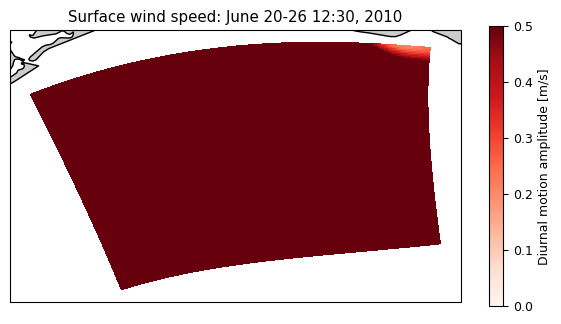

In [39]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(221, projection=ccrs.PlateCarree())
pcA = ax.pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice), ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice), np.abs(Ai_wind), 
                     cmap=plt.cm.Reds, transform=ccrs.PlateCarree(), vmin=0, vmax=0.5)
plt.colorbar(pcA).set_label('Diurnal motion amplitude [m/s]')

ax.add_feature(land_10m, facecolor='0.8', linewidth = 1) # add land
ax.coastlines(resolution='10m', linewidth = 1)  # add coastlines 
ax.add_feature(cartopy.feature.RIVERS, lw = 2) # add rivers
ax.set_title('Surface wind speed: June 20-26 12:30, 2010')

Text(0.5, 1.0, 'Surface wind stress: June 20-26 12:30, 2010')

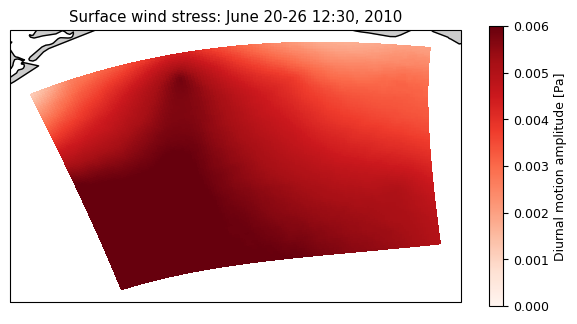

In [40]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(221, projection=ccrs.PlateCarree())
pcA = ax.pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice), ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice), np.abs(Ai_windstr), 
                     cmap=plt.cm.Reds, transform=ccrs.PlateCarree(), vmin=0, vmax=0.006)
plt.colorbar(pcA).set_label('Diurnal motion amplitude [Pa]')

ax.add_feature(land_10m, facecolor='0.8', linewidth = 1) # add land
ax.coastlines(resolution='10m', linewidth = 1)  # add coastlines 
ax.add_feature(cartopy.feature.RIVERS, lw = 2) # add rivers
ax.set_title('Surface wind stress: June 20-26 12:30, 2010')

### That variability seems very large - let's calculate 95\% confidence intervals and add them to the plot

In [41]:
def calc_CI(arr, CI):
    #Spatial mean at each time
    arr_mean = arr.mean() 
    
    #Spatial standard deviation at each time
    arr_std = arr.std() 
    
    #Add prescribed confidence interval to spatial mean
    if CI == 95:
        arr_errp = arr_mean+(1.95996*(arr_std))
        arr_errm = arr_mean-(1.95996*(arr_std))
        
    if CI == 99:
        arr_errp = arr_mean+(2.57583*(arr_std))
        arr_errm = arr_mean-(2.57583*(arr_std))
        
    #Merge all variables to a master array
    arr_com = np.array([arr_mean, arr_std, arr_errm, arr_errp])
    return arr_com 

In [42]:
arr = np.sqrt(np.abs(Ai_wind)).values; CI = 95
diu_winspd = calc_CI(arr, CI)
diu_winspd

array([1.54683492, 0.22292376, 1.10991328, 1.98375657])

In [43]:
arr = np.sqrt(np.abs(Ai_windstr)).values; CI = 95
diu_winstr = calc_CI(arr, CI)
diu_winstr

array([0.06866955, 0.00908765, 0.05085812, 0.08648098])

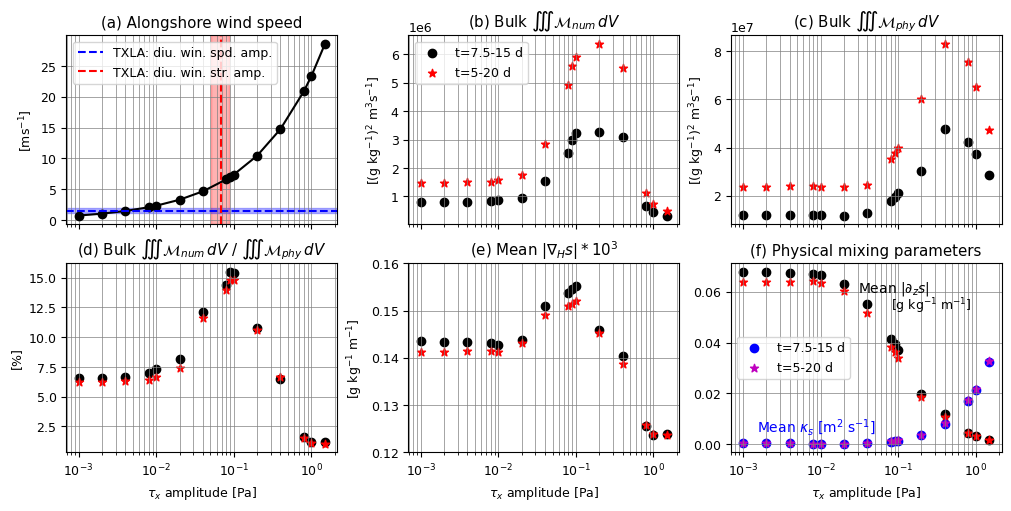

In [188]:
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(2,3, figsize = (10,5), constrained_layout = True)

uideal = np.sqrt(tx/(rhoa*cd))
ax[0,0].semilogx(tx, uideal, color = 'k', marker = 'o')
ax[0,0].set_ylabel(r'[ms$^{-1}$]')
ax[0,0].set_xlabel(r'$\tau_x$ [Pa]')
ax[0,0].grid(which = 'both')
ax[0,0].set_title('(a) Alongshore wind speed')
ax[0,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[0,0].axhline(1.547, c = 'b', ls = '--', label = 'TXLA: diu. win. spd. amp.')
ax[0,0].axvspan(0.05085812, 0.08648098, color = 'r', alpha = 0.3)
ax[0,0].axvline(0.0687, c = 'r', ls = '--', label = 'TXLA: diu. win. str. amp.')
ax[0,0].axhspan(1.10991328, 1.98375657, color = 'b', alpha = 0.3)

ax[0,0].legend()

ax[0,1].scatter(tx,r1, c = 'k', label = 't=7.5-15 d')
ax[0,1].scatter(tx,r3, c = 'r', marker = '*', label = 't=5-20 d')
ax[0,1].set_xlabel(r'')
ax[0,1].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,1].set_title(r'(b) Bulk $\iiint \mathcal{M}_{num} \, dV$')
ax[0,1].legend()

ax[0,2].scatter(tx,r2, c = 'k')
ax[0,2].scatter(tx,r4, c = 'r', marker = '*')
ax[0,2].set_xlabel(r'')
ax[0,2].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,2].set_title(r'(c) Bulk $\iiint \mathcal{M}_{phy} \, dV$')

ax[1,0].scatter(tx,np.array(r)*100, c = 'k')
ax[1,0].scatter(tx,np.array(rextend)*100, c = 'r', marker = '*')
ax[1,0].set_xlabel(r'')
ax[1,0].set_ylabel(r'[%]')
ax[1,0].set_title(r'(d) Bulk $\iiint \mathcal{M}_{num} \, dV$ / $\iiint \mathcal{M}_{phy} \, dV$')
ax[1,0].grid(which = 'both')

ax[1,1].scatter(tx,np.array(s)*1000, c = 'k')
ax[1,1].scatter(tx,np.array(s1)*1000, c = 'r', marker = '*')
ax[1,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,1].set_ylabel(r'[g kg$^{-1}$ m$^{-1}$]')
ax[1,1].set_title(r'(e) Mean $|\nabla_H s|*10^3$')
ax[1,1].set_ylim(0.12, 0.16)

ax[1,2].scatter(tx, np.abs(sv), c = 'k', label = '')
ax[1,2].scatter(tx,np.abs(sv1), c = 'r', marker = '*')
ax[1,2].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].set_ylabel(r'')
ax[1,2].set_title(r'(f) Physical mixing parameters')
ax[1,2].scatter(tx, diffu, c = 'b', label = 't=7.5-15 d')
ax[1,2].scatter(tx, diffu1, c = 'm', label = 't=5-20 d', marker = '*')
ax[1,2].legend(loc='center left')

for i in range(2):
    for j in range(3):
        ax[i,j].semilogx()
        ax[0,j].set_xticklabels('')
        # ax[i,j].semilogy(base = 2)
        ax[0,i].set_xlabel('')
        ax[i,j].grid(which = 'both', ls = '-', c = 'grey', lw = 0.5)
ax[1,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].text(0.0015,0.005,'Mean $\kappa_s$ [m$^2$ s$^{-1}$]', color = 'blue', fontsize = 10)
ax[1,2].text(0.03,0.06,'Mean $|\partial_z s|$', color = 'black', fontsize = 10)# 
ax[1,2].text(0.08,0.053,'[g kg$^{-1}$ m$^{-1}$]', color = 'black', fontsize = 9)# 
# plt.savefig('mixing_function_taux.jpg', dpi = 300)

### So - the amplitude of the diurnal motions over the shelf is far less energetic than the wind stress prescribed in shelfstrat

Text(0.08, 0.053, '[g kg$^{-1}$ m$^{-1}$]')

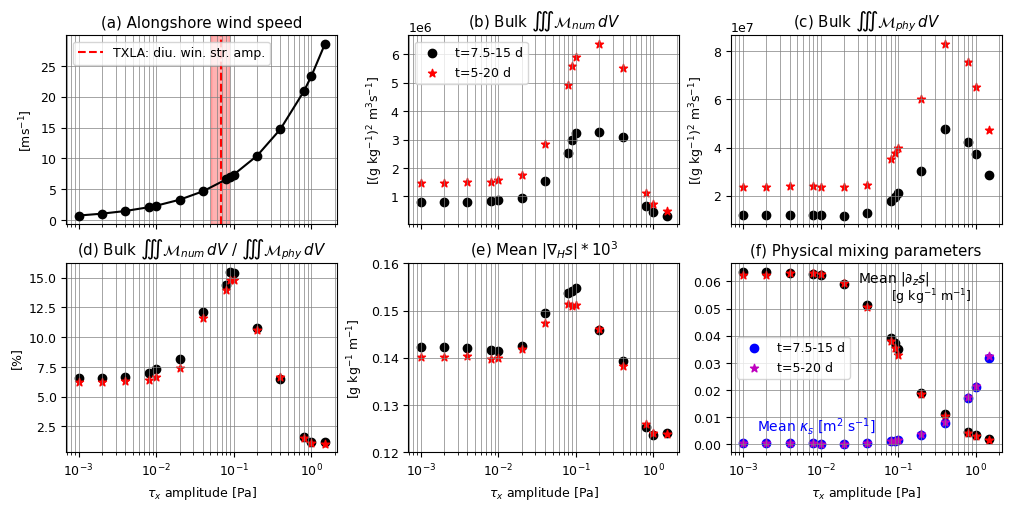

In [44]:
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(2,3, figsize = (10,5), constrained_layout = True)

uideal = np.sqrt(tx/(rhoa*cd))
ax[0,0].semilogx(tx, uideal, color = 'k', marker = 'o')
ax[0,0].set_ylabel(r'[ms$^{-1}$]')
ax[0,0].set_xlabel(r'$\tau_x$ [Pa]')
ax[0,0].grid(which = 'both')
ax[0,0].set_title('(a) Alongshore wind speed')
ax[0,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
# ax[0,0].axhline(1.547, c = 'b', ls = '--', label = 'TXLA: diu. win. spd. amp.')
ax[0,0].axvspan(0.05085812, 0.08648098, color = 'r', alpha = 0.3)
ax[0,0].axvline(0.0687, c = 'r', ls = '--', label = 'TXLA: diu. win. str. amp.')
# ax[0,0].axhspan(1.10991328, 1.98375657, color = 'b', alpha = 0.3)

ax[0,0].legend()

ax[0,1].scatter(tx,r1, c = 'k', label = 't=7.5-15 d')
ax[0,1].scatter(tx,r3, c = 'r', marker = '*', label = 't=5-20 d')
ax[0,1].set_xlabel(r'')
ax[0,1].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,1].set_title(r'(b) Bulk $\iiint \mathcal{M}_{num} \, dV$')
ax[0,1].legend()

ax[0,2].scatter(tx,r2, c = 'k')
ax[0,2].scatter(tx,r4, c = 'r', marker = '*')
ax[0,2].set_xlabel(r'')
ax[0,2].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,2].set_title(r'(c) Bulk $\iiint \mathcal{M}_{phy} \, dV$')

ax[1,0].scatter(tx,np.array(r)*100, c = 'k')
ax[1,0].scatter(tx,np.array(rextend)*100, c = 'r', marker = '*')
ax[1,0].set_xlabel(r'')
ax[1,0].set_ylabel(r'[%]')
ax[1,0].set_title(r'(d) Bulk $\iiint \mathcal{M}_{num} \, dV$ / $\iiint \mathcal{M}_{phy} \, dV$')
ax[1,0].grid(which = 'both')

ax[1,1].scatter(tx,np.array(s)*1000, c = 'k')
ax[1,1].scatter(tx,np.array(s1)*1000, c = 'r', marker = '*')
ax[1,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,1].set_ylabel(r'[g kg$^{-1}$ m$^{-1}$]')
ax[1,1].set_title(r'(e) Mean $|\nabla_H s|*10^3$')
ax[1,1].set_ylim(0.12, 0.16)

ax[1,2].scatter(tx, np.abs(sv), c = 'k', label = '')
ax[1,2].scatter(tx,np.abs(sv1), c = 'r', marker = '*')
ax[1,2].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].set_ylabel(r'')
ax[1,2].set_title(r'(f) Physical mixing parameters')
ax[1,2].scatter(tx, diffu, c = 'b', label = 't=7.5-15 d')
ax[1,2].scatter(tx, diffu1, c = 'm', label = 't=5-20 d', marker = '*')
ax[1,2].legend(loc='center left')

for i in range(2):
    for j in range(3):
        ax[i,j].semilogx()
        ax[0,j].set_xticklabels('')
        # ax[i,j].semilogy(base = 2)
        ax[0,i].set_xlabel('')
        ax[i,j].grid(which = 'both', ls = '-', c = 'grey', lw = 0.5)
ax[1,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].text(0.0015,0.005,'Mean $\kappa_s$ [m$^2$ s$^{-1}$]', color = 'blue', fontsize = 10)
ax[1,2].text(0.03,0.06,'Mean $|\partial_z s|$', color = 'black', fontsize = 10)# 
ax[1,2].text(0.08,0.053,'[g kg$^{-1}$ m$^{-1}$]', color = 'black', fontsize = 9)# 
# plt.savefig('mixing_function_taux.jpg', dpi = 300)

### Now add in dashed lines for the base case 

In [56]:
path1 = '/d2/home/dylan/idealized_nummix/shelf_mpdata_uwind_zero_dt_30_60d_avg.nc'
ds_base = xroms.open_netcdf(path1)
ds_base, grid_base = xroms.roms_dataset(ds_base)

def mix_vint(ds, grid, etaslice, xislice):
    mnum = ds.dye_03.isel(eta_rho = etaslice, xi_rho = xislice) #Numerical salt mixing
    mphy = ds.AKr.isel(eta_rho = etaslice, xi_rho = xislice) #Destruction of salt variance
    #Interpolate to the s-rho points 
    mphy = grid.interp(mphy, 'Z')
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    #Volume integrate, then name for concat
    mnum_int = (mnum*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mnum_int.attrs = [] # Remove grid so we can save to netcdf 
    mnum_int.name = 'mnum_int'
    mphy_int = (mphy*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mphy_int.name = 'mphy_int'

    ds_mix = xr.merge([mnum_int, mphy_int])
    return ds_mix

#Slice over the 50 km plume and save to a netcdf
etaslice = slice(1,100)
xislice = slice(1,-1)

dsb_mix = mix_vint(ds_base,grid_base,etaslice,xislice)

In [77]:
tslice1 = slice(120,361+96+24)
print(ds_base.isel(ocean_time = tslice).ocean_time[0].values)
print(ds_base.isel(ocean_time = tslice).ocean_time[-1].values)

tslice = slice(120+60,361)
print(ds_base.isel(ocean_time = tslice1).ocean_time[0].values)
print(ds_base.isel(ocean_time = tslice1).ocean_time[-1].values)

0001-01-06 00:30:00
0001-01-21 00:30:00
0001-01-06 00:30:00
0001-01-21 00:30:00


In [78]:
(dsb_mix.mnum_int.isel(ocean_time = tslice).sum().values)/(dsb_mix.mphy_int.isel(ocean_time = tslice).sum().values)

0.06485485472260044

In [79]:
r_base = dsb_mix.mnum_int.isel(ocean_time = tslice).sum().values/(dsb_mix.mphy_int.isel(ocean_time = tslice).sum().values)
r_base1 = dsb_mix.mnum_int.isel(ocean_time = tslice1).sum().values/(dsb_mix.mphy_int.isel(ocean_time = tslice1).sum().values)
print(r_base)
print(r_base1)

0.06485485472260044
0.061244291188632075


In [92]:
def sgradmag_mean(ds, grid, tslice, etaslice, xislice):
    '''
Computes the horz. salinity gradient magnitude for the entire
water column on the psi points.
    ''' 
    dsaltdxi, dsaltdeta = xroms.hgrad(ds.salt, grid)
    dsaltdxi_rho = xroms.to_rho(dsaltdxi, grid)
    dsaltdeta_rho = xroms.to_rho(dsaltdeta, grid)
    sgradmag = (dsaltdxi_rho**2+dsaltdeta_rho**2)**(1/2)
    sgradmag_srho = grid.interp(sgradmag, 'Z', boundary = 'extend')
    smean = sgradmag_srho.isel(ocean_time = tslice, eta_rho = etaslice, xi_rho = xislice).mean(['ocean_time', 'xi_rho', 's_rho', 'eta_rho']).values
    return smean

smean_base = sgradmag_mean(ds_base, grid_base, tslice, etaslice, xislice)
smean_base1 = sgradmag_mean(ds_base, grid_base, tslice1, etaslice, xislice)

def dsdz(ds, grid, tslice, etaslice, xislice):
    '''
Computes the vertical salinity gradient magnitude for the entire
water column on the psi points.
    ''' 
    dsdz = xroms.ddz(ds.salt, grid)
    dsdz_srho = grid.interp(dsdz, 'Z', boundary = 'extend')
    dsdz_srho.attrs = ''
    dsdz_srho.name = 'dsdz'
    svmean = dsdz_srho.isel(ocean_time = tslice, eta_rho = etaslice, xi_rho = xislice).mean(['ocean_time', 'xi_rho', 's_rho', 'eta_rho']).values   
    return svmean

svmean_base = dsdz(ds_base,grid_base,tslice,etaslice,xislice)
svmean_base1 = dsdz(ds_base,grid_base,tslice1,etaslice,xislice)

def vert_diffusivity(ds, grid, tslice, etaslice, xislice):
    '''
Computes the vertical salinity gradient magnitude for the entire
water column on the psi points.
    ''' 
    aks = ds.AKs
    aks_srho = grid.interp(aks, 'Z', boundary = 'extend')
    aks_srho.attrs = ''
    aks_srho.name = 'aks'
    aksmean = aks_srho.isel(ocean_time = tslice, eta_rho = etaslice, xi_rho = xislice).mean(['ocean_time', 'xi_rho', 's_rho', 'eta_rho']).values   
    return aksmean

aksmean_base = vert_diffusivity(ds_base,grid_base,tslice,etaslice,xislice)
aksmean_base1 = vert_diffusivity(ds_base,grid_base,tslice1,etaslice,xislice)

### Now add in lines for the unforced case 

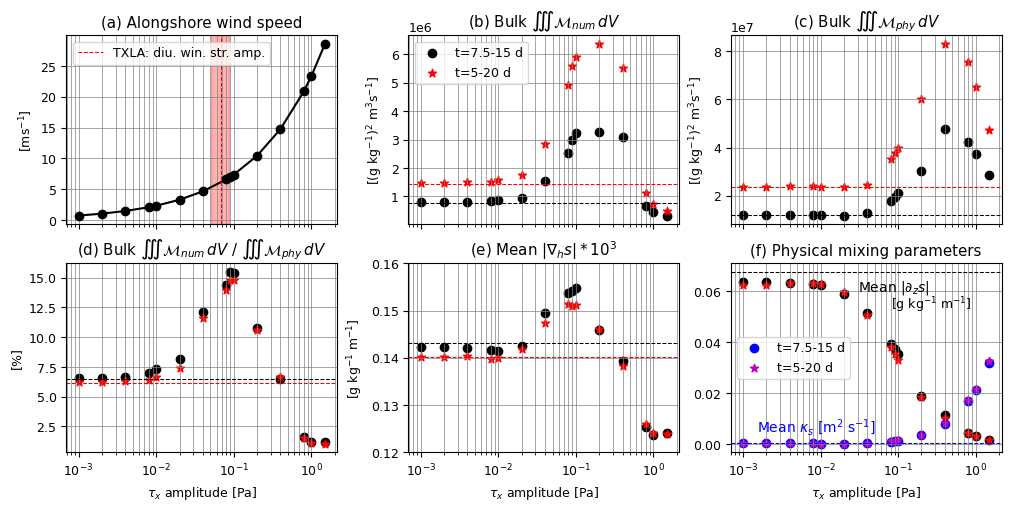

In [103]:
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(2,3, figsize = (10,5), constrained_layout = True)

uideal = np.sqrt(tx/(rhoa*cd))
ax[0,0].semilogx(tx, uideal, color = 'k', marker = 'o')
ax[0,0].set_ylabel(r'[ms$^{-1}$]')
ax[0,0].set_xlabel(r'$\tau_x$ [Pa]')
ax[0,0].grid(which = 'both')
ax[0,0].set_title('(a) Alongshore wind speed')
ax[0,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
# ax[0,0].axhline(1.547, c = 'b', ls = '--', label = 'TXLA: diu. win. spd. amp.')
ax[0,0].axvspan(0.05085812, 0.08648098, color = 'r', alpha = 0.3)
ax[0,0].axvline(0.0687, c = 'r', ls = '--', lw = 0.75, label = 'TXLA: diu. win. str. amp.')
# ax[0,0].axhspan(1.10991328, 1.98375657, color = 'b', alpha = 0.3)

ax[0,0].legend()

ax[0,1].scatter(tx,r1, c = 'k', label = 't=7.5-15 d')
ax[0,1].scatter(tx,r3, c = 'r', marker = '*', label = 't=5-20 d')
ax[0,1].set_xlabel(r'')
ax[0,1].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,1].set_title(r'(b) Bulk $\iiint \mathcal{M}_{num} \, dV$')
ax[0,1].legend()

ax[0,1].axhline((dsb_mix.mnum_int.isel(ocean_time = tslice).sum().values), c = 'k', ls = '--', lw = 0.75)
ax[0,1].axhline((dsb_mix.mnum_int.isel(ocean_time = tslice1).sum().values), c = 'r', ls = '--', lw = 0.75)

ax[0,2].scatter(tx,r2, c = 'k')
ax[0,2].scatter(tx,r4, c = 'r', marker = '*')
ax[0,2].set_xlabel(r'')
ax[0,2].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,2].set_title(r'(c) Bulk $\iiint \mathcal{M}_{phy} \, dV$')

ax[0,2].axhline((dsb_mix.mphy_int.isel(ocean_time = tslice).sum().values), c = 'k', ls = '--', lw = 0.75)
ax[0,2].axhline((dsb_mix.mphy_int.isel(ocean_time = tslice1).sum().values), c = 'r', ls = '--', lw = 0.75)

ax[1,0].scatter(tx,np.array(r)*100, c = 'k')
ax[1,0].scatter(tx,np.array(rextend)*100, c = 'r', marker = '*')
ax[1,0].set_xlabel(r'')
ax[1,0].set_ylabel(r'[%]')
ax[1,0].set_title(r'(d) Bulk $\iiint \mathcal{M}_{num} \, dV$ / $\iiint \mathcal{M}_{phy} \, dV$')
ax[1,0].grid(which = 'both')

ax[1,0].axhline(r_base*100, c = 'k', ls = '--', lw = 0.75)
ax[1,0].axhline(r_base1*100, c = 'r', ls = '--', lw = 0.75)

ax[1,1].scatter(tx,np.array(s)*1000, c = 'k')
ax[1,1].scatter(tx,np.array(s1)*1000, c = 'r', marker = '*')
ax[1,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,1].set_ylabel(r'[g kg$^{-1}$ m$^{-1}$]')
ax[1,1].set_title(r'(e) Mean $|\nabla_h s|*10^3$')
ax[1,1].set_ylim(0.12, 0.16)

ax[1,1].axhline(smean_base*1000, c = 'k', ls = '--', lw = 0.75)
ax[1,1].axhline(smean_base1*1000, c = 'r', ls = '--', lw = 0.75)

ax[1,2].scatter(tx, np.abs(sv), c = 'k', label = '')
ax[1,2].scatter(tx,np.abs(sv1), c = 'r', marker = '*')
ax[1,2].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].set_ylabel(r'')
ax[1,2].set_title(r'(f) Physical mixing parameters')
ax[1,2].scatter(tx, diffu, c = 'b', label = 't=7.5-15 d')
ax[1,2].scatter(tx, diffu1, c = 'm', label = 't=5-20 d', marker = '*')
ax[1,2].legend(loc='center left')

ax[1,2].axhline(np.abs(svmean_base), c = 'k', ls = '--', lw = 0.75)
ax[1,2].axhline(aksmean_base, c = 'b', ls = '--', lw = 0.75)

for i in range(2):
    for j in range(3):
        ax[i,j].semilogx()
        ax[0,j].set_xticklabels('')
        ax[0,i].set_xlabel('')
        ax[i,j].grid(which = 'both', ls = '-', c = 'grey', lw = 0.5)
ax[1,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].text(0.0015,0.005,'Mean $\kappa_s$ [m$^2$ s$^{-1}$]', color = 'blue', fontsize = 10)
ax[1,2].text(0.03,0.06,'Mean $|\partial_z s|$', color = 'black', fontsize = 10)# 
ax[1,2].text(0.08,0.053,'[g kg$^{-1}$ m$^{-1}$]', color = 'black', fontsize = 9)# 
plt.savefig('mixing_function_taux.jpg', dpi = 300)